In [1]:
import pandas as pd
import numpy as np
import random

In [2]:
### First, using raw 2020 Pulse survey data, get conditional probabilities by income and education bucket

Survey files downloaded from here: https://www.census.gov/programs-surveys/household-pulse-survey/datasets.html

These are the variables in the survey we care about

EEDUC  
1) Less than high school  
2) Some high school  
3) High school graduate or equivalent (for example GED)  
4) Some college, but degree not received or is in progress  
5) Associate’s degree (for example AA, AS)  
6) Bachelor's degree (for example BA, BS, AB)  
7) Graduate degree (for example master's, professional, doctorate)  


TW_START   
1) Yes, at least one adult substituted some or all of their typical in-person work for telework  
2) No, no adults substituted their typical in-person work for telework  
3) No, there has been no change in telework  
-99) Question seen but category not selected  
-88) Missing / Did not report   


INCOME  
1) Less than 25,000  
2) 25,000 - 34,999  
3) 35,000 - 49,999  
4) 50,000 - 74,999  
5) 75,000 - 99,999  
6) 100,000 - 149,999  
7) 150,000 - 199,999  
8) 200,000 and above  
-99) Question seen but category not selected  
-88) Missing / Did not report  

In [3]:
cols_use = ["PWEIGHT","TW_START","INCOME","EEDUC"]
pulse_df = pd.read_csv("pulse2021_week22_survey.csv")[cols_use]
### Label income, education, wfh

def pulse_income_prob_label(inp_income):
        if inp_income == 8:
            return '7) 200K+'
        elif inp_income == 7:
            return '6) 150-200K'
        elif inp_income == 6:
            return '5) 100-150K'
        elif inp_income == 5:
            return '4) 75-100K'
        elif inp_income == 4:
            return '3) 50-75K'
        elif inp_income ==3:
            return '2) 35-50K'
        elif inp_income ==2:
            return '1) 25-35K'
        elif inp_income ==1:
            return '0) 0-25K'
        else:
            return "no income - drop"
        
def pulse_educ_label(inp_educ):
    if inp_educ in [6,7]:
        return 1
    elif inp_educ in [1,2,3,4,5]:
        return 0
    else:
        return -99
    
        
def pulse_wfh_label(inp_wfh):
    if inp_wfh in [1]:
        return 1
    elif inp_wfh in [2,3]:
        return 0
    else:
        return -99
    

pulse_df['INC_TAG'] = pulse_df["INCOME"].apply(pulse_income_prob_label)
pulse_df['EDUC_TAG'] = pulse_df["EEDUC"].apply(pulse_educ_label)
pulse_df['WFH_TAG'] = pulse_df["TW_START"].apply(pulse_wfh_label)

print("Overall Weights Summed: ",round(pulse_df["PWEIGHT"].sum()))
print("Dropped because of nulls/non-answers: ",round(pulse_df[(pulse_df['INC_TAG'].str.contains("drop"))|(pulse_df['EDUC_TAG']=='99')|(pulse_df['WFH_TAG']==-99)]["PWEIGHT"].sum()))

pulse_df = pulse_df[~(pulse_df['INC_TAG'].str.contains("drop"))&~(pulse_df['EDUC_TAG']=='99')&~(pulse_df['WFH_TAG']==-99)].copy()
print(f"Weights Remaining: ",round(pulse_df["PWEIGHT"].sum()))


# Get the number of people who wfh by each income and education tag
cross_cts = pulse_df.groupby(by=["INC_TAG","EDUC_TAG",'WFH_TAG']).agg({"PWEIGHT":"sum"}).reset_index()
tots = cross_cts.groupby(by=["INC_TAG","EDUC_TAG"]).agg({"PWEIGHT":"sum"})
tots.rename({"PWEIGHT":"total"},axis=1,inplace=True)
# get the conditional probabilty of WFH given each INC and EDUC
cross_cts=cross_cts.merge(right=tots,left_on=["INC_TAG","EDUC_TAG"],right_index=True)
cross_cts["PROB WFH | INC * EDUC"] = cross_cts["PWEIGHT"]/cross_cts["total"]
# only save WFH probability - we dont need the inverse
cross_cts_save = cross_cts[cross_cts['WFH_TAG']==1]

cross_cts_save[['INC_TAG',"EDUC_TAG","WFH_TAG","PROB WFH | INC * EDUC"]]

Overall Weights Summed:  249170916
Dropped because of nulls/non-answers:  85569014
Weights Remaining:  163601902


,INC_TAG,EDUC_TAG,WFH_TAG,PROB WFH | INC * EDUC
1,0) 0-25K,0,1,0.124650
3,0) 0-25K,1,1,0.429435
5,1) 25-35K,0,1,0.137290
7,1) 25-35K,1,1,0.362040
9,2) 35-50K,0,1,0.184655
11,2) 35-50K,1,1,0.486698
13,3) 50-75K,0,1,0.282278
15,3) 50-75K,1,1,0.532137
17,4) 75-100K,0,1,0.374457
19,4) 75-100K,1,1,0.595087


In [4]:
cross_cts_save[['INC_TAG',"EDUC_TAG","WFH_TAG","PROB WFH | INC * EDUC"]].to_csv("wfh_conditional_probs.csv")

In [5]:
### Read in ipums data
ipums_df = pd.read_csv("../ipums_data/disaggregated_cleaned_ipums_data.csv",index_col=0)
ipums_df = ipums_df[ipums_df['YEAR']==2019].reset_index(drop=True) #2019 only

In [6]:
print(len(ipums_df))
ipums_df.head(1)

23978


,YEAR,PERWT,HOME_STATEFIP,HOME_PUMA,PUMA_NAME,SEX,AGE,HRS_WK_DAILY,TOTAL_PERSONAL_INCOME,MODE_TRANSP_TO_WORK,...,PUMAKEY_HOME,PUMAKEY_WORK,DISTANCE_KM,COGNITIVE_DIFFICULTY,AMBULATORY_DIFFICULTY,IND_LIVING_DIFFICULTY,SELFCARE_DIFFICULTY,VISION_OR_HEARING_DIFFICULTY,VISION_DIFFICULTY,HEARING_DIFFICULTY
0,2019,23.0,9,500,Litchfield County,F,46,7.4,3800,"Auto, truck, or van",...,09_00500,36_03800,170.50491,0,0,0,0,0,0,0


In [7]:
### Tag income and education data according to the ways the Pulse survey groups answers

def income_prob_label(inp_income):
        if inp_income >= 200000:
            return '7) 200K+'
        elif inp_income >= 150000:
            return '6) 150-200K'
        elif inp_income >= 100000:
            return '5) 100-150K'
        elif inp_income >= 75000:
            return '4) 75-100K'
        elif inp_income >= 50000:
            return '3) 50-75K'
        elif inp_income >= 35000:
            return '2) 35-50K'
        elif inp_income >= 25000:
            return '1) 25-35K'
        else:
            return '0) 0-25K'
        
def educ_label(inp_educ):
    if inp_educ in ['College_4Year','College_5PlusYears']:
        return 1
    else:
        return 0

In [8]:
ipums_df['INC_TAG'] = ipums_df["TOTAL_PERSONAL_INCOME"].apply(income_prob_label)
ipums_df['EDUC_TAG'] = ipums_df["EDUC_LABEL"].apply(educ_label)
ipums_df['INC_TAG'].value_counts(),ipums_df['EDUC_TAG'].value_counts()

(3) 50-75K      4247
 0) 0-25K       3691
 5) 100-150K    3634
 7) 200K+       3357
 4) 75-100K     3006
 2) 35-50K      2509
 1) 25-35K      1825
 6) 150-200K    1709
 Name: INC_TAG, dtype: int64,
 1    15622
 0     8356
 Name: EDUC_TAG, dtype: int64)

In [9]:
### Read in WFH conditional probabilities from above work

wfh_probs = pd.read_csv("wfh_conditional_probs.csv",index_col=0).drop("WFH_TAG",axis=1)
print(wfh_probs.dtypes)
wfh_probs.head(5)


INC_TAG                   object
EDUC_TAG                   int64
PROB WFH | INC * EDUC    float64
dtype: object


,INC_TAG,EDUC_TAG,PROB WFH | INC * EDUC
1,0) 0-25K,0,0.124650
3,0) 0-25K,1,0.429435
5,1) 25-35K,0,0.137290
7,1) 25-35K,1,0.362040
9,2) 35-50K,0,0.184655


In [10]:
### WFH function here:

def wfh_flag_binary(wfh_dampener):
    '''  
    Changable inputs:
    wfh_dampener: decimal 0-1
        if 1, then just use probs as is.
        if <1, multiply probabilities by dampener to reduce WFH population
        if 0, nobody will WFH
    
    WFH taken as a conditional prob of income and education from Census Household Pulse Survey results last year
    
    output:
        series (0,1) indicating whether each line is a likely WFH candidate
    '''   
    
    if wfh_dampener < 0 or wfh_dampener > 1:
        return "Not a valid dampener"
    
    
    industries_cannot_wfh = ["Educational Services, and Health Care and Social Assistance"\
                            ,"Arts, Entertainment, and Recreation, and Accommodation and Food Services"\
                            ,"Retail Trade", "Construction"\
                            ,"Other Services, Except Public Administration"\
                            ,"Transportation and Warehousing, and Utilities","Manufacturing"\
                            ,"Agriculture, Forestry, Fishing, and Hunting, and Mining"]
    

    
    industry_binary = ipums_df["IND_CAT"].apply(lambda x: 0 if x in industries_cannot_wfh else 1)
    wfh_probabilities = ipums_df.merge(right=wfh_probs,on=["INC_TAG","EDUC_TAG"])["PROB WFH | INC * EDUC"]
    wfh_binary = wfh_probabilities.apply(lambda x: 1 if random.random() <= x*wfh_dampener else 0)
    
    wfh_overall_binary = industry_binary&wfh_binary
    
    return wfh_overall_binary
    
    

In [11]:
ipums_df["FLAG_WFH"]=wfh_flag_binary(wfh_dampener=1)
ipums_df.groupby(by=['YEAR','FLAG_WFH'],dropna=False).agg({"PERWT":"sum"})/ipums_df.PERWT.sum()

PERWT
YEAR FLAG_WFH          
2019 0         0.748386
     1         0.251614

In [12]:
check_df = ipums_df.copy() #just to make checks simpler
check_df["INC_TAG_VAL"] = check_df["INC_TAG"].apply(lambda x: int(x.split(")")[0]))
check_df["INC_TAG_VAL"].value_counts()

3    4247
0    3691
5    3634
7    3357
4    3006
2    2509
1    1825
6    1709
Name: INC_TAG_VAL, dtype: int64

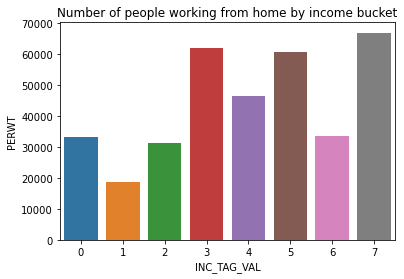

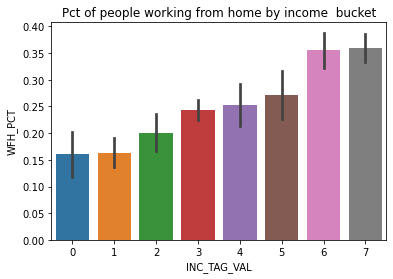

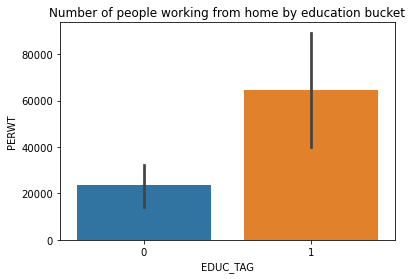

''

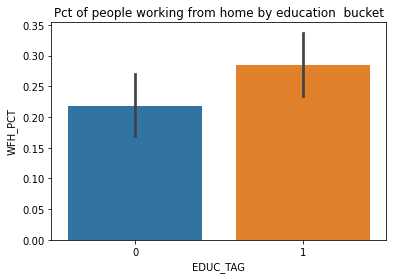

In [13]:
check_df[["INC_TAG_VAL","EDUC_TAG","FLAG_WFH","PERWT"]]
check_gb = check_df.groupby(by=["INC_TAG_VAL","EDUC_TAG","FLAG_WFH"]).agg({"PERWT":"sum"}).reset_index()

totals = check_gb.groupby(by=["INC_TAG_VAL","EDUC_TAG"]).agg({"PERWT":"sum"}).reset_index()
totals.rename({"PERWT":"TOTAL"},axis=1,inplace=True)
check_gb = check_gb.merge(right=totals,on=["INC_TAG_VAL","EDUC_TAG"])
check_gb["WFH_PCT"] = check_gb["PERWT"]/check_gb["TOTAL"]

wfh_plot_df = check_gb[check_gb['FLAG_WFH']==1]
plt.title("Number of people working from home by income bucket")
sns.barplot(data=wfh_plot_df,x='INC_TAG_VAL',y='PERWT',ci=None)
plt.show();

plt.title("Pct of people working from home by income  bucket")
sns.barplot(data=wfh_plot_df,x='INC_TAG_VAL',y='WFH_PCT')
plt.show();

plt.title("Number of people working from home by education bucket")
sns.barplot(data=wfh_plot_df,x='EDUC_TAG',y='PERWT')
plt.show()

plt.title("Pct of people working from home by education  bucket")
sns.barplot(data=wfh_plot_df,x='EDUC_TAG',y='WFH_PCT')
;

Dampener: 0.0 - total WFH IDs 0.0
Dampener: 0.1 - total WFH IDs 75104.0
Dampener: 0.2 - total WFH IDs 142223.0
Dampener: 0.3 - total WFH IDs 217137.0
Dampener: 0.4 - total WFH IDs 281141.0
Dampener: 0.5 - total WFH IDs 349413.0
Dampener: 0.6 - total WFH IDs 422931.0
Dampener: 0.7 - total WFH IDs 493155.0
Dampener: 0.8 - total WFH IDs 578598.0
Dampener: 0.9 - total WFH IDs 643168.0
Dampener: 1.0 - total WFH IDs 727756.0


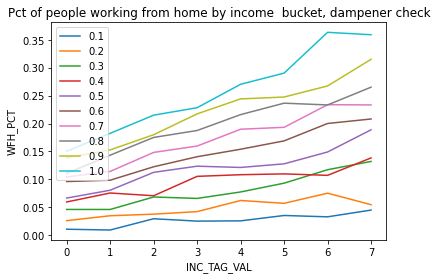

In [14]:
### Dampener Check
val_list = list()

for dampener in np.arange(0,1.01,.1):
#     print(dampener)
    dampener_check_df = ipums_df.copy()
    dampener_check_df["FLAG_WFH"]=wfh_flag_binary(wfh_dampener=dampener)
    dampener_check_df["INC_TAG_VAL"] = dampener_check_df["INC_TAG"].apply(lambda x: int(x.split(")")[0]))
    
    dampener_gb = dampener_check_df.groupby(by=["INC_TAG_VAL","EDUC_TAG","FLAG_WFH"]).agg({"PERWT":"sum"}).reset_index()

    totals = dampener_gb.groupby(by=["INC_TAG_VAL","EDUC_TAG"]).agg({"PERWT":"sum"}).reset_index()
    totals.rename({"PERWT":"TOTAL"},axis=1,inplace=True)
    dampener_gb = dampener_gb.merge(right=totals,on=["INC_TAG_VAL","EDUC_TAG"])
    dampener_gb["WFH_PCT"] = dampener_gb["PERWT"]/dampener_gb["TOTAL"]
    
    wfh_plot_df = dampener_gb[dampener_gb['FLAG_WFH']==1]
    val_list.append((dampener,wfh_plot_df))
    
fig,ax=plt.subplots()    
ax.set_title("Pct of people working from home by income  bucket, dampener check")
for val, df in val_list:
    sns.lineplot(data=df,x='INC_TAG_VAL',y='WFH_PCT',label=round(val,1),ax=ax,ci=None)
#     print(df["WFH_PCT"].describe())
    print(f"Dampener: {round(val,1)} - total WFH IDs",df["PERWT"].sum())
    
    